# Transition Path

In this notebook, I solve and simulate the housing model along a **transition path** stemming from an interest rate shock

In [252]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import funcs as f
from scipy import stats

# load the DurableConsumptionModel module
from HousingModel import HousingModelClass

# Set the number of threads in numba
nb.set_num_threads(3)

# Smoother
# from scipy.signal import savgol_filter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Find Equilibrium Along a Transition Path

I apply a relaxation algorithm where I use a ghost run along the path as the benchmark to update equilibrium prices

In [253]:
# Define the model
taug = 0.0 # baseline w/o gains tax
model = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'taug':taug, 'do_print':False})

# # Solve and simulate
model.precompile_numba()
model.solve()
model.simulate()

Ghost run - simulate path without an interest rate drop

In [ ]:
# No drop in interest rates
model.par.R_drop = 0.0

# Solve and simulate along the path
model.solve_path()
model.simulate_path()

Define ghost path

In [62]:
# Define ghost run path
H_ghost = np.mean(model.sim_path.d, axis=1)

NameError: name 'model' is not defined

## Apply relaxation algorithm 

In [3]:
# Initialize model and solve initial steady state
model_path = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})
model_path.precompile_numba()
model_path.solve()
model_path.simulate() # simulate initial ss

In [4]:
model_path.par.R_drop = 0.0
model_path.par.taug = 0.0
model_path.solve_path()
model_path.simulate_path()

In [5]:
H_ghost = np.mean(model_path.sim_path.d, axis=1)

In [6]:
model_path.par.R_drop = 0.005

Check how the partial eq. impulse response looks

In [8]:
# a. allocate
path_ph = np.zeros(model_path.par.path_T + model_path.par.T)

# b. setting - 0.9999
nu = 0.1 # relaxation parameter
max_iter = 1000 # maximum number of iterations

# # c. Set path of prices
path_ph[:] = model_path.par.ph
model_path.par.path_ph = path_ph

# d. iterate
it = 0
for _ in range(max_iter):

    # ii. solve and simulate
    model_path.solve_path()
    model_path.simulate_path()

    # iii. Implied aggregate housing demand
    H = np.mean(model_path.sim_path.d, axis=1)
    
    # iv. difference
    max_abs_diff = np.max(np.abs(H[:-2] - H_ghost[:-2]))
    # if it%10 == 0: print(f'{it:4d}: {max_abs_diff:.8f}')
    if max_abs_diff < 10e-4: break # test different values of this threshold

    # v. update
    path_ph[:model_path.par.path_T] = path_ph[:model_path.par.path_T] + nu*(H - H_ghost)
    path_ph[model_path.par.path_T:] = path_ph[model_path.par.path_T-3] # think about this term
    
    model_path.par.path_ph = path_ph    
    
    # vi.  increment
    it += 1
    if it > max_iter: raise Exception('too many iterations')    
    
    print('p_max is ' +str(path_ph[0]))
    print(str(it)+'th iteration: dif = '+str(max_abs_diff))

p_max is 1.0110286997510225
1th iteration: dif = 0.11125348553629277
p_max is 1.021724527525717
2th iteration: dif = 0.10695827774694466
p_max is 1.0320550241943645
3th iteration: dif = 0.10405177267016708
p_max is 1.0423011752040547
4th iteration: dif = 0.10319334978623007
p_max is 1.0518440921638035
5th iteration: dif = 0.09832324769866396
p_max is 1.0612617602817274
6th iteration: dif = 0.09965243436596527
p_max is 1.0698311357619439
7th iteration: dif = 0.09586224403891919
p_max is 1.078908078741628
8th iteration: dif = 0.09290979988957448
p_max is 1.0882935326604315
9th iteration: dif = 0.0938545391880341
p_max is 1.0968210258473867
10th iteration: dif = 0.0852749318695527
p_max is 1.1056962766091347
11th iteration: dif = 0.08875250761747999
p_max is 1.1145314572563556
12th iteration: dif = 0.08835180647220975
p_max is 1.122696833839651
13th iteration: dif = 0.08558481507980775
p_max is 1.1308573571292824
14th iteration: dif = 0.08458874060973476
p_max is 1.1376392590875435
15th i

Traceback (most recent call last):
  File "C:\Users\madsh\OneDrive - University of Copenhagen\Desktop\Thesis\code\MA_thesis\HousingModel.py", line 623, in simulate_path
    simulate.monte_carlo(sim_path,sol_path,par,path=True)
KeyboardInterrupt


KeyboardInterrupt: 

## Plot the Impulse Responses

Define path of aggregates, so that it starts 10 periods before the shock

In [90]:
p_path_base = np.zeros(10+model_path.par.path_T)
p_path_base[0:10] = model_path.par.ph
p_path_base[10:] = model_path.par.path_ph[0:model_path.par.path_T] / model_path.par.ph

c_path_base = np.zeros(10+model_path.par.path_T)
c_path_base[0:10] = np.mean(model_path.sim.c, axis=1)[-10:] / np.mean(model_path.sim.c, axis=1)[-1:]
c_path_base[10:] = np.mean(model_path.sim_path.c, axis=1)/ np.mean(model_path.sim.c, axis=1)[-1:]

a_path_base = np.zeros(10+model_path.par.path_T)
a_path_base[0:10] = np.mean(model_path.sim.a, axis=1)[-10:] / np.mean(model_path.sim.a, axis=1)[-1:]
a_path_base[10:] = np.mean(model_path.sim_path.a, axis=1) / np.mean(model_path.sim.a, axis=1)[-1:]

t_axis = range(-10,200) # Time from shock

Equilibrium housing price

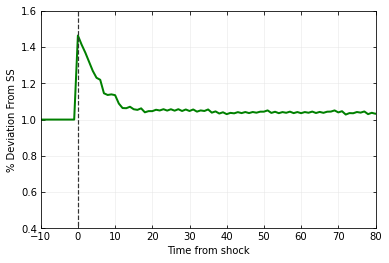

In [109]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, p_path_base, color = 'green', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,80)
# ax.set_ylim(6.98,7.53)
ax.set_ylim(0.4,1.6)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_ph.pdf')

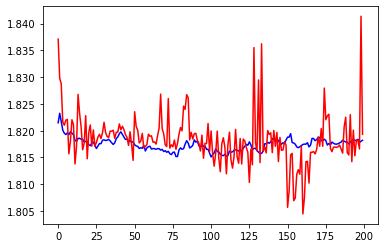

In [112]:
plt.plot(H_ghost, color = 'blue')
plt.plot( np.mean(model_path.sim_path.d, axis=1), color = 'red')

Non-durable consumption

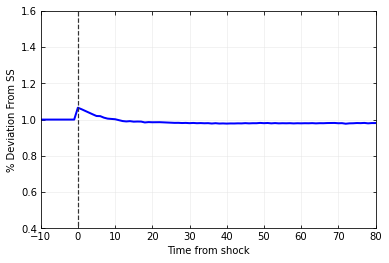

In [153]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, c_path_base, color = 'blue', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,80)
ax.set_ylim(0.4,1.6)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_c.pdf')

Cash on hand

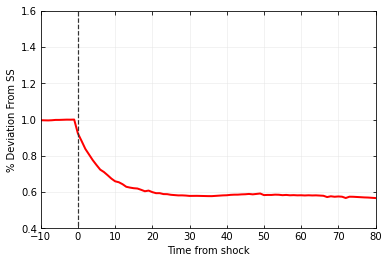

In [111]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, a_path_base, color = 'red', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,80)
ax.set_ylim(0.4,1.6)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../tex/figs/IRF_m.pdf')

## Plot the path of the Gini coefficient

Generate panel for path

In [114]:
# For ease
par = model_path.par
sim = model_path.sim
sim_path = model_path.sim_path

In [149]:
# Generate path of wealth
w = np.zeros(shape=(par.path_T+10,par.simN))

for k in range(-10,par.T-10):
    
    t = k + 10
    # print('t =  '+str(t) +' k = '+str(k))
    if k < 0:
        w[t] = sim.m[k] + par.ph*sim.n[k]

    else:
        w[t] = sim_path.m[k] + par.path_ph[k]*sim_path.n[k]

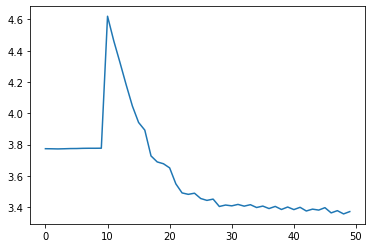

In [150]:
plt.plot(np.mean(w,axis=1)[0:50])

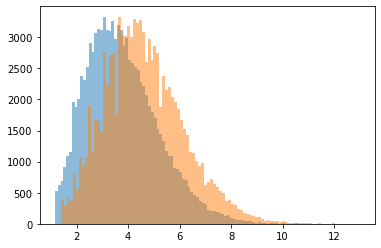

In [156]:
plt.hist(w[9,:], bins = 100, alpha =.5)
plt.hist(w[10,:], bins = 100, alpha =.5)

plt.show()

Compute gain from $t=0$ to $t=1$

In [219]:
# gain = (par.path_ph[0]*sim_path.n[0,:] + sim_path.m[0,:] - par.ph*sim.n[-1,:] - sim.m[-1,:]) / (par.ph*sim.n[-1,:] + sim.m[-1,:])
gain = (par.path_ph[0]*sim_path.n[0,:] - par.ph*sim.n[-1,:]) / (par.ph*sim.n[-1,:])

In [223]:
# try binned scatterplot
gains_means, bin_edges, binnumber = stats.binned_statistic(sim.m[-1,:],gain, bins = 20, statistic = 'mean')

# Compute bins
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

In [237]:
# regression line
res = stats.linregress(sim.m[-1,:], gain)
y_fit = res.intercept + res.slope*par.grid_m

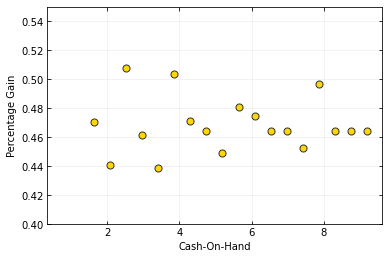

In [239]:
# Initialize the figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.scatter(bin_centers, gains_means, s=50, c='gold', marker='o', edgecolors = '0.2', zorder=2) 
# ax.plot(par.grid_m,y_fit)

# Plot setting
ax.set_xlabel('Cash-On-Hand')
ax.set_ylabel('Percentage Gain')

# ax.set_xlim(0,200)
ax.set_ylim(0.4,.55)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend()

plt.savefig('../../tex/figs/gains_bins.pdf')

In [151]:
gini_path = np.zeros(par.path_T+10)

for t in range(par.path_T):
    gini_path[t] = f.gini(w[t,:])

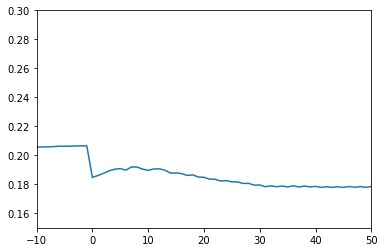

In [152]:
t = np.linspace(-10,199,210, dtype = int)

plt.plot(t,gini_path)
plt.xlim(-10,50)
plt.ylim(.15,.3)
plt.show()

# Test the transition path with avancebeskatning

In [225]:
# Initialize model and solve initial steady state
model_path = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})

# Solve and simulate
model_path.precompile_numba()
model_path.solve()
model_path.simulate()

H_ghost = np.mean(model_path.sim_path.d, axis=1)

In [226]:
model_path.par.taug = 0.01
model_path.solve_path()
model_path.simulate_path()

In [240]:
# a. allocate
path_ph = np.zeros(model_path.par.path_T + model_path.par.T)

# b. setting - 0.9999
nu = .05 # relaxation parameter
max_iter = 1000 # maximum number of iterations

# # c. Set path of prices
path_ph[:] = model_path.par.ph
model_path.par.path_ph = path_ph

# d. iterate
it = 0
for _ in range(max_iter):

    # ii. solve and simulate
    model_path.solve_path()
    model_path.simulate_path()

    # iii. Implied aggregate housing demand
    H = np.mean(model_path.sim_path.d, axis=1)
    
    # iv. difference
    max_abs_diff = np.max(np.abs(H[:-2] - H_ghost[:-2]))
    # if it%10 == 0: print(f'{it:4d}: {max_abs_diff:.8f}')
    if max_abs_diff < 10e-3: break # test different values of this threshold

    # v. update
    path_ph[:model_path.par.path_T] = path_ph[:model_path.par.path_T] + nu*(H - H_ghost)
    path_ph[model_path.par.path_T:] = path_ph[model_path.par.path_T-3]
    
    model_path.par.path_ph = path_ph    
    
    # vi.  increment
    it += 1
    if it > max_iter: raise Exception('too many iterations')    
    
    print(str(it)+'th iteration: dif = '+str(max_abs_diff))
    print('p_max is ' +str(path_ph[0]))

1th iteration: dif = 1.9345517394342469
p_max is 1.0967275869717124
2th iteration: dif = 1.9088805527111368
p_max is 1.1921716146072692
3th iteration: dif = 1.8805799387031124
p_max is 1.2861852625179488
4th iteration: dif = 1.8562347006487951
p_max is 1.3789969975503886
5th iteration: dif = 1.8326548738210688
p_max is 1.4706297412414422
6th iteration: dif = 1.8138673743316382
p_max is 1.561323109958024
7th iteration: dif = 1.7959613967601142
p_max is 1.6511211797960297
8th iteration: dif = 1.7791243789536075
p_max is 1.7400773987437101
9th iteration: dif = 1.7515436737991499
p_max is 1.8276545824336676


Traceback (most recent call last):
  File "C:\Users\madsh\OneDrive - University of Copenhagen\Desktop\Thesis\code\MA_thesis\HousingModel.py", line 623, in simulate_path
    simulate.monte_carlo(sim_path,sol_path,par,path=True)
KeyboardInterrupt


KeyboardInterrupt: 

In [241]:
p_path_g = np.zeros(10+model_path.par.path_T)
p_path_g[0:10] = model_path.par.ph
p_path_g[10:] = model_path.par.path_ph[0:model_path.par.path_T]

c_path_g = np.zeros(10+model_path.par.path_T)
c_path_g[0:10] = np.mean(model_path.sim.c, axis=1)[-10:]
c_path_g[10:] = np.mean(model_path.sim_path.c, axis=1)

a_path_g = np.zeros(10+model_path.par.path_T)
a_path_g[0:10] = np.mean(model_path.sim.a, axis=1)[-10:]
a_path_g[10:] = np.mean(model_path.sim_path.a, axis=1)

t_axis = range(-10,200) # Time from shock

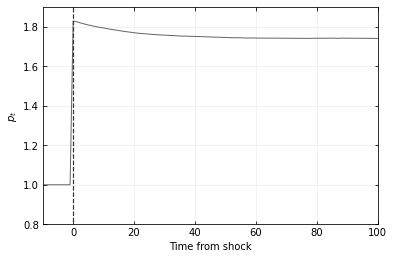

In [251]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, p_path_g, color = '0.4', linestyle='-', linewidth=1,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,100)
ax.set_ylim(.8,1.9)
# ax.set_ylim(0.99,1.7)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'$p_t$')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

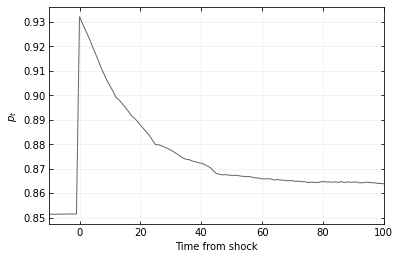

In [248]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, c_path_g, color = '0.4', linestyle='-', linewidth=1,  label = 'Demand',zorder=2)
# ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,100)
# ax.set_ylim(6.98,7.53)
# ax.set_ylim(0.99,1.02)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'$p_t$')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

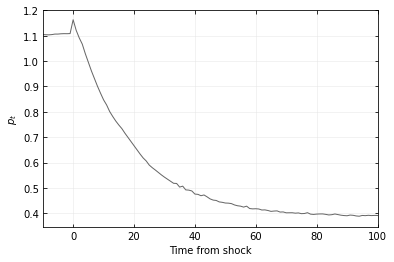

In [249]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, a_path_g, color = '0.4', linestyle='-', linewidth=1,  label = 'Demand',zorder=2)
# ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,100)
# ax.set_ylim(6.98,7.53)
# ax.set_ylim(0.99,1.02)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'$p_t$')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')